# Predicting Residential Energy Consumption Using CNN-LSTM Neural Networks

The dataset used in this project is the *Individual household electric power consumption* dataset, which is publicly available from the UCI Machine Learning Repository:

http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

According to the paper, the features used in the experiments are as follows:

| #  | Attribute             | Description                                                                                     |
|----|-----------------------|-------------------------------------------------------------------------------------------------|
| 1  | Day                   | An integer value between 1 and 31                                                              |
| 2  | Month                 | An integer value between 1 and 12                                                              |
| 3  | Year                  | An integer value between 2006 and 2010                                                         |
| 4  | Hour                  | An integer value between 0 and 23                                                              |
| 5  | Minute                | An integer value between 1 and 60                                                              |
| 6  | Global active power (GAP)  | Household global minute-averaged active power (in kilowatt)                              |
| 7  | Global reactive power (GRP)| Household global minute-averaged reactive power (in kilowatt)                            |
| 8  | Voltage               | Minute-averaged voltage (in volt)                                                              |
| 9  | Global intensity (GI) | Household global minute-averaged current intensity (in ampere)                                |
| 10 | Sub metering 1 (S1)   | Kitchen: dishwasher, oven, microwave (in watt-hour of active energy)                          |
| 11 | Sub metering 2 (S2)   | Laundry room: washing machine, tumble-drier, refrigerator, light (in watt-hour of active energy)|
| 12 | Sub metering 3 (S3)   | Electric water heater and air conditioner (in watt-hour of active energy)                     |


In [67]:
# Pakages
import sys
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter

from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.random import set_seed

from keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, MaxPooling2D, Conv2D, Dropout, Flatten, RepeatVector, LSTM, TimeDistributed, Dense
from keras.optimizers import SGD

from IPython.display import Image


To ensure reproducibility, we set a random seed as follows:

In [68]:
set_seed(68)

## Importing the Data and Data Processing

We start by downloading the dataset directly from the UCI Machine Learning Repository using `wget`, and then unzip the file to extract the contents.

In [69]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!unzip household_power_consumption.zip

--2025-05-09 09:05:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘household_power_consumption.zip.1’

household_power_con     [        <=>         ]  19.68M  9.23MB/s    in 2.1s    

2025-05-09 09:05:06 (9.23 MB/s) - ‘household_power_consumption.zip.1’ saved [20640916]

Archive:  household_power_consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: household_power_consumption.txt  


Before loading the entire dataset, we preview the first few rows to understand its structure and formatting.

In [70]:
pd.read_csv('household_power_consumption.txt', sep=';', nrows=5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


We now load the full dataset. Note that both `"nan"` and `"?"` are treated as missing values and converted to `np.nan` during import.
The `"Date"` and `"Time"` columns are merged into a single `"dt"` column, which is also set as the time-based index to convert the data into a proper time series format.



In [71]:
import pandas as pd

df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'dt' : ['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=False,
                 na_values=['nan','?'],
                 index_col='dt')

<ipython-input-71-05dd2890f420>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-71-05dd2890f420>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-71-05dd2890f420>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt',


Now, we will get an overview of the dataset.

In [72]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [74]:
df.shape

(2075259, 7)

In [75]:
df.describe(include="all")

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


The summary statistics obtained using `.describe()` closely match those reported in the original paper.



In [76]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [77]:
df.isnull().sum().to_frame(name="Missing Values")

,Missing Values
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


The number of missing values in our dataset is consistent with the 25,979 missing entries mentioned in Section 4.1 of the paper.
Following the same preprocessing procedure, we now remove all rows with missing values as described:


In [78]:
# Drop all rows containing any NaN values
df = df.dropna()

# Verify that no missing values remain
print(df.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [79]:
df.shape

(2049280, 7)

## Exploratory Data Analysis and Feature Engineering

According to the paper, Global Active Power (GAP) is the target variable for prediction.
To better understand its behavior over different time resolutions, we visualize its average values on minutely, hourly, daily, and weekly scales.

<ipython-input-80-19ea68523f88>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Global_active_power'].resample('H').mean().plot(ax=axes[0, 1], title='Hourly Mean', color='steelblue')


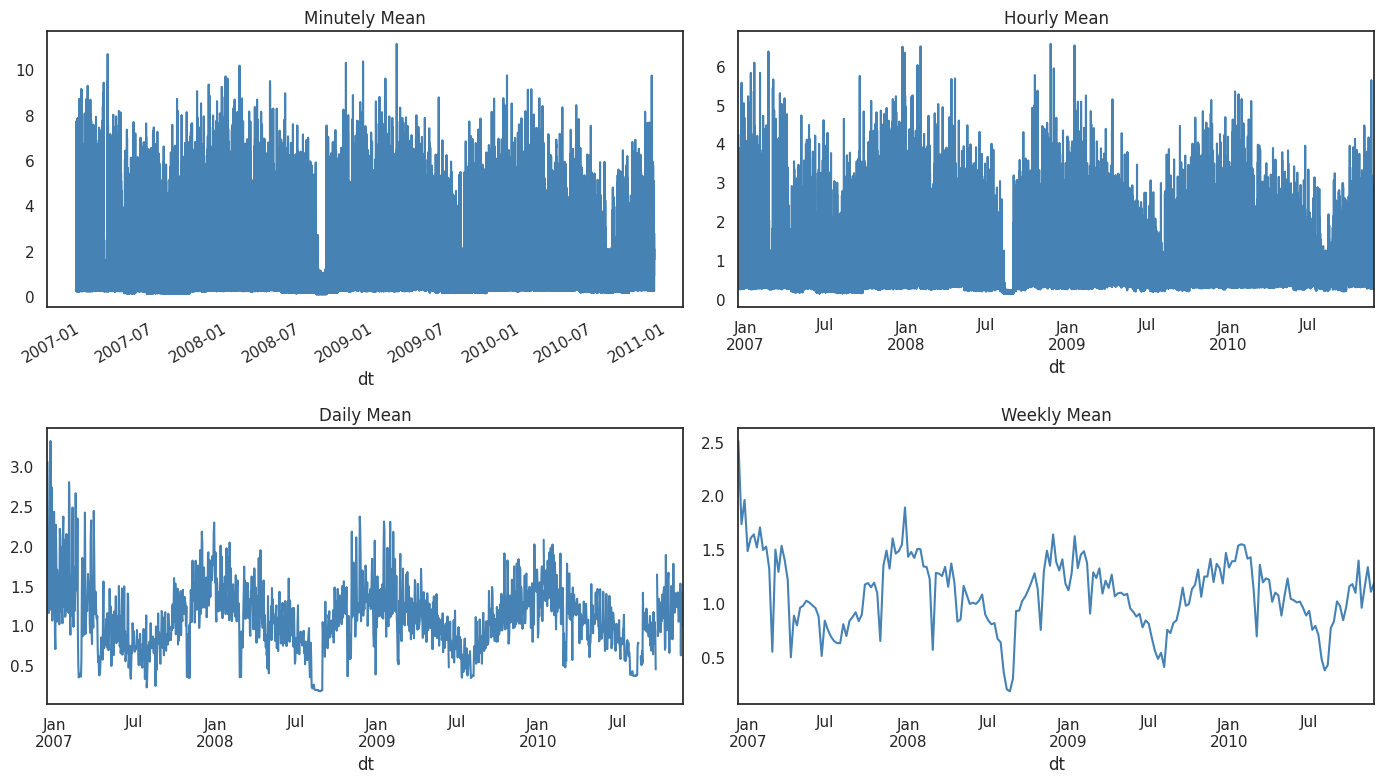

In [80]:
# Create subplots to visualize different time resolutions
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Minutely mean (original resolution; optionally smoothed via rolling average)
df['Global_active_power'].plot(ax=axes[0, 0], title='Minutely Mean', color='steelblue')

# Hourly mean
df['Global_active_power'].resample('H').mean().plot(ax=axes[0, 1], title='Hourly Mean', color='steelblue')

# Daily mean
df['Global_active_power'].resample('D').mean().plot(ax=axes[1, 0], title='Daily Mean', color='steelblue')

# Weekly mean
df['Global_active_power'].resample('W').mean().plot(ax=axes[1, 1], title='Weekly Mean', color='steelblue')

# Apply tight layout for better spacing
plt.tight_layout()
plt.show()


As the time granularity becomes coarser, the plot becomes smoother and reveals clearer long-term patterns and seasonal trends.
The minutely and hourly views show high short-term fluctuations, while the daily and weekly averages highlight broader consumption trends over time.



To better understand the distribution of each variable in the dataset, we plot histograms with kernel density estimates (KDE) for all features:

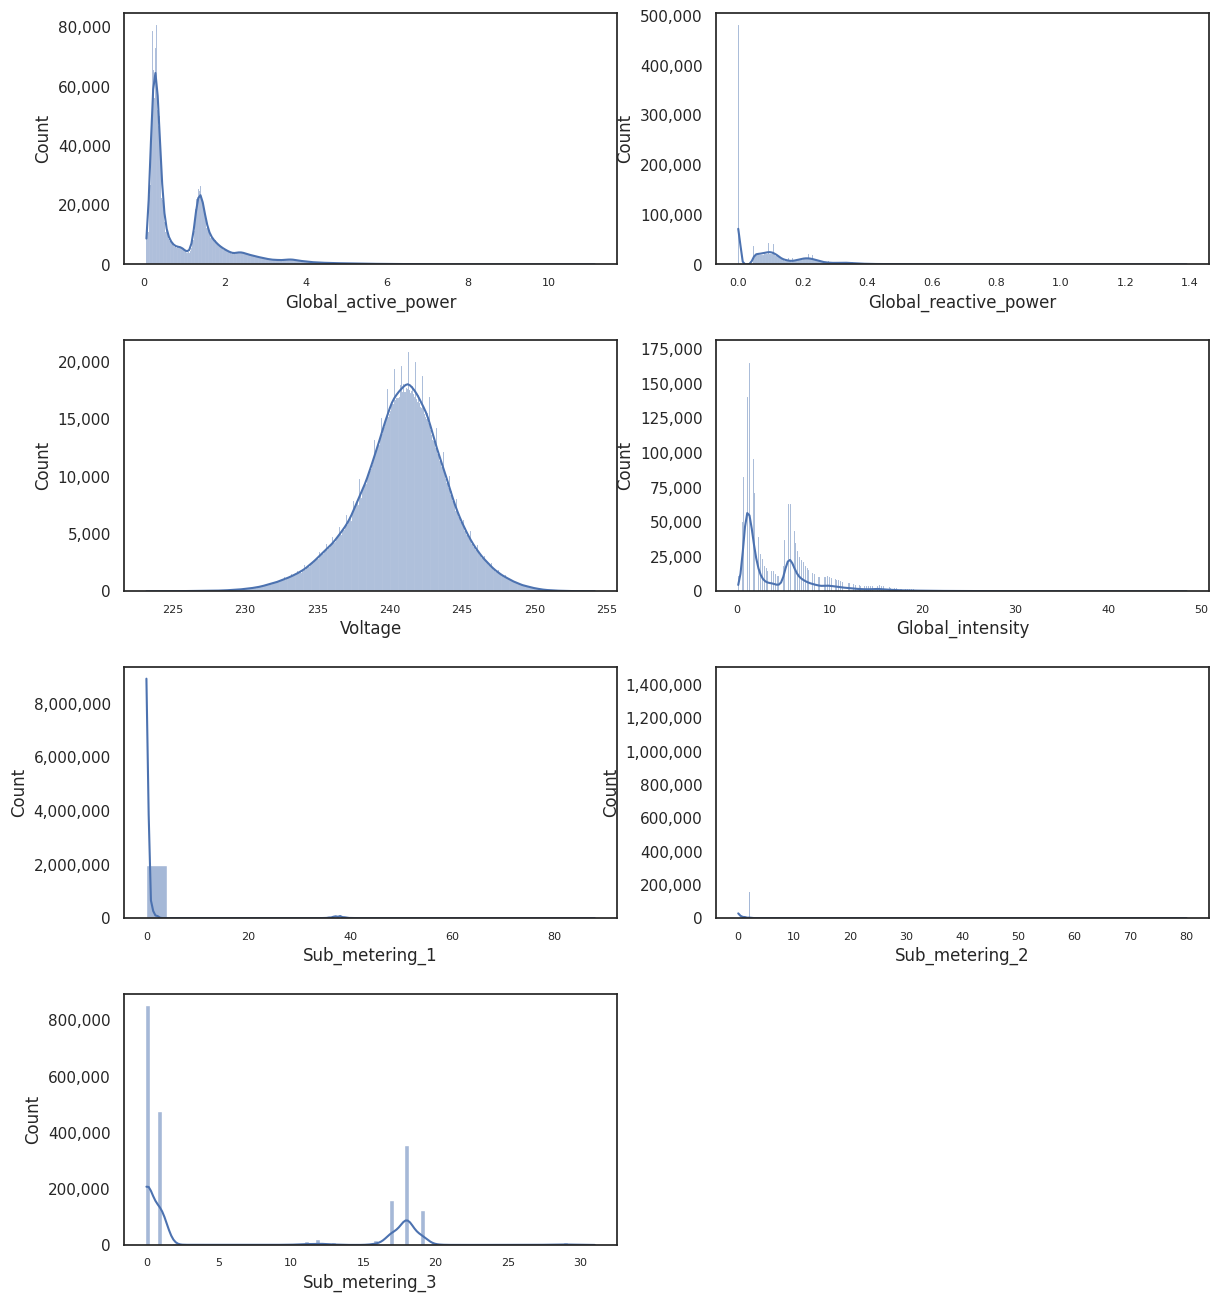

In [81]:
columns = df.columns

fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=df, ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3);


* **Global\_active\_power**, **Global\_reactive\_power**, and **Global\_intensity** are all right-skewed, with a large concentration of values near zero and long tails. This suggests the presence of short bursts of high power usage.Additionally, we observe that Global_active_power and Global_intensity exhibit very similar distribution patterns.
* **Voltage** follows a roughly normal distribution, centered around 240V, with small variance — indicating stable household voltage over time.
* **Sub\_metering\_1** and **Sub\_metering\_2** are highly sparse, with most values at or near zero. Occasional peaks suggest device-specific usage events (e.g., microwave, washer).
* **Sub\_metering\_3** shows a multi-modal distribution, possibly due to regular patterns from high-consumption devices like water heaters and air conditioners.


To better understand daily consumption patterns, we resample the dataset to a daily frequency and plot the average values of selected features over time:

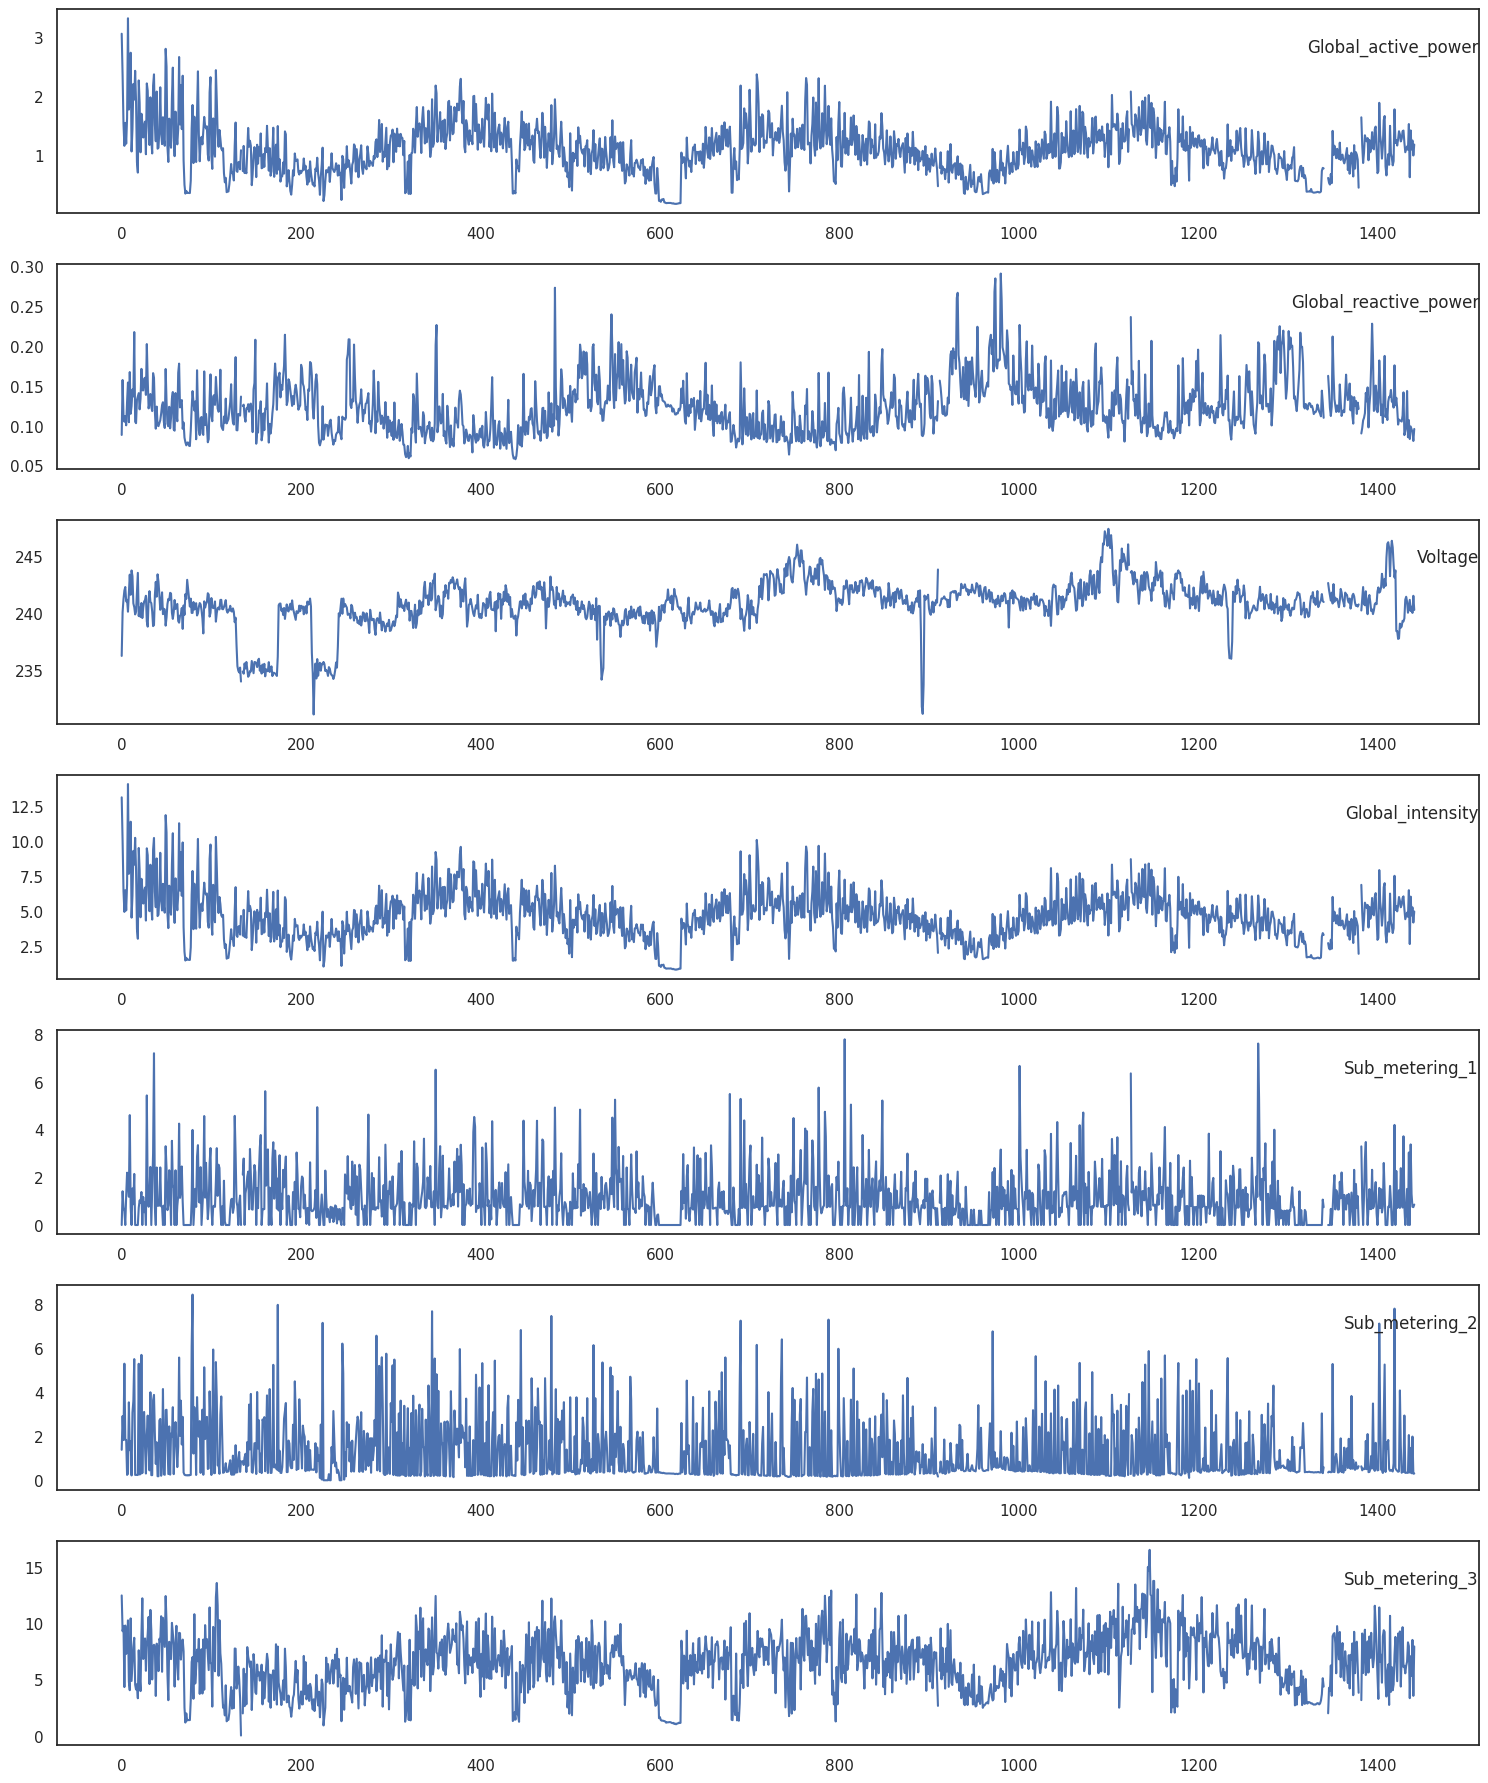

In [82]:
# Resample the dataset to daily frequency
resampled = df.resample('D').mean()

# Plot all features (skip none)
columns = resampled.columns
values = resampled.values

plt.figure(figsize=(15, 18))
for i, col in enumerate(columns, 1):
    plt.subplot(len(columns), 1, i)
    plt.plot(values[:, i-1])
    plt.title(col, y=0.75, loc='right')

plt.tight_layout()
plt.show()


* **Global\_active\_power** and **Global\_intensity** show closely correlated patterns, reflecting their physical relationship (power = voltage × current).
* **Global\_reactive\_power** and **Voltage** exhibit more subtle fluctuations, though occasional shifts or drops in voltage can still be observed.
* **Sub\_metering\_1**, **2**, and **3** demonstrate high variability and intermittent spikes, indicating device-specific usage patterns.
* Some seasonal trends and long-term shifts in overall energy consumption can be visually identified.

To observe broader consumption trends and reduce short-term noise, we compute the weekly average of several key features and plot them together for comparison:

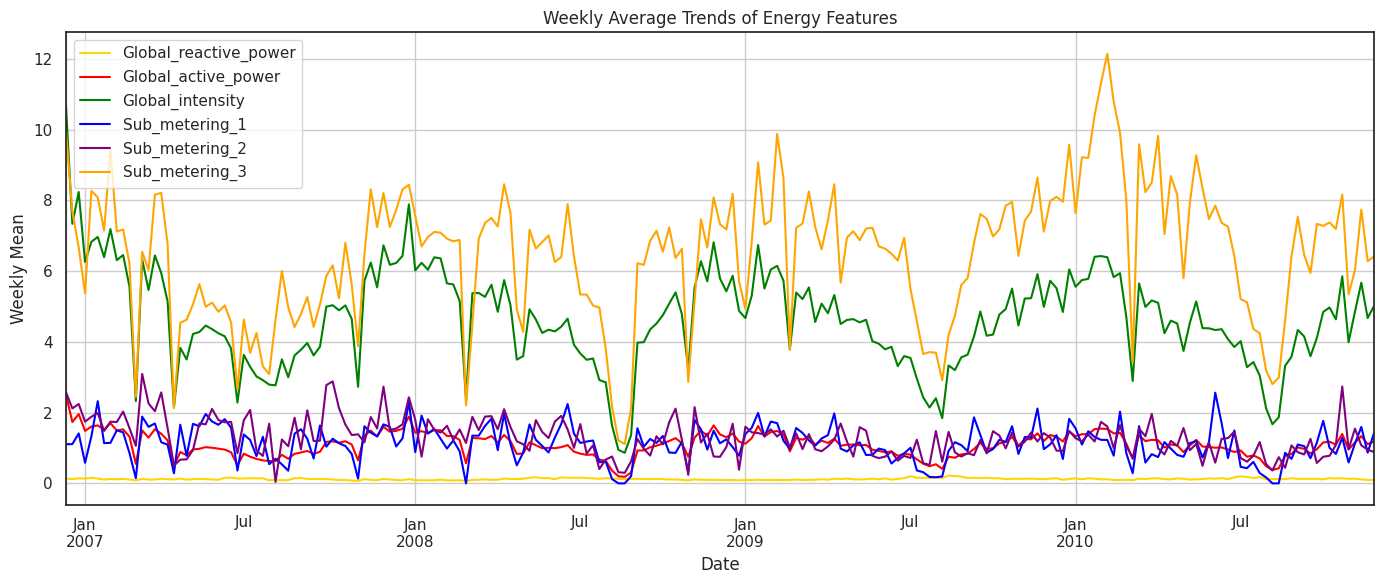

In [83]:
# Weekly resampling and plotting for all key features
plt.figure(figsize=(14, 6))

df.Global_reactive_power.resample('W').mean().plot(label='Global_reactive_power', color='gold')
df.Global_active_power.resample('W').mean().plot(label='Global_active_power', color='red')
df.Global_intensity.resample('W').mean().plot(label='Global_intensity', color='green')
df.Sub_metering_1.resample('W').mean().plot(label='Sub_metering_1', color='blue')
df.Sub_metering_2.resample('W').mean().plot(label='Sub_metering_2', color='purple')
df.Sub_metering_3.resample('W').mean().plot(label='Sub_metering_3', color='orange')

plt.legend()
plt.title("Weekly Average Trends of Energy Features")
plt.xlabel("Date")
plt.ylabel("Weekly Mean")
plt.grid(True)
plt.tight_layout()
plt.show()



The plot shows weekly average trends of all major energy features, highlighting seasonal fluctuations and the dominant contribution of **Sub\_metering\_3** and **Global\_intensity** to overall power usage.

<ipython-input-84-792868791d7f>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
<ipython-input-84-792868791d7f>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='g', legend=True)
<ipython-input-84-792868791d7f>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.Global_intensity.resample('M').mean().plot(kind='hist', color='b', legend=True)
<ipython-input-84-792868791d7f>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)


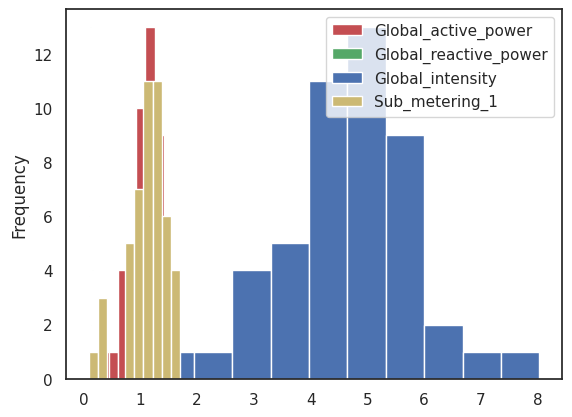

In [84]:
# Monthly mean histograms for selected features
df.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='g', legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist', color='b', legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)
plt.show()

Based on these plots, we observe that the features have different scales and distributions. Therefore, we will apply feature standardization before feeding the data into the model, to ensure all variables contribute equally to learning.



Outliers:

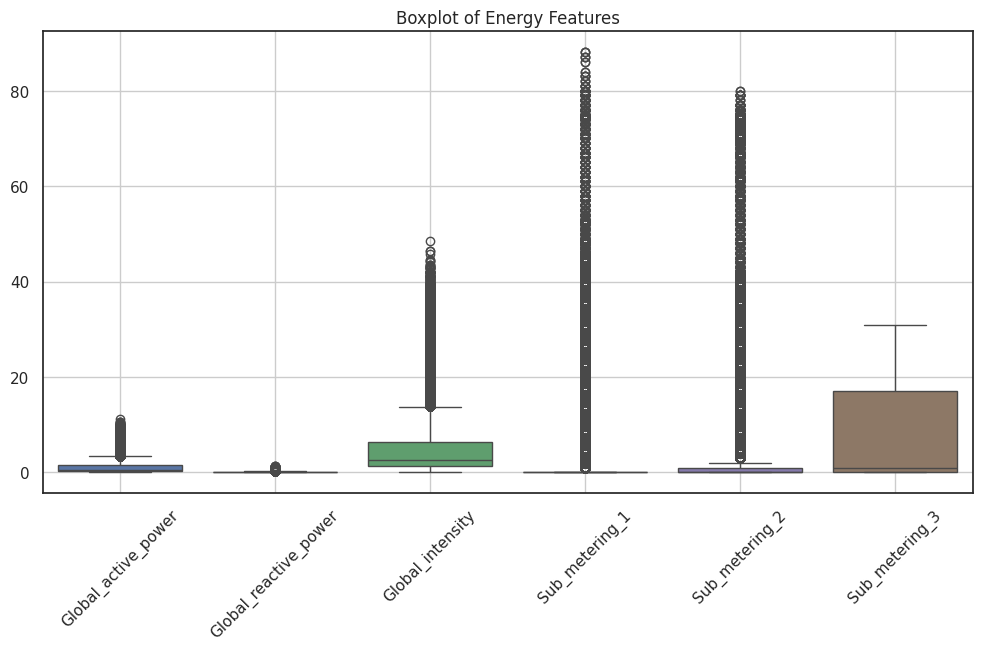

In [85]:
# Select numerical features
features = ['Global_active_power', 'Global_reactive_power', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[features])
plt.title("Boxplot of Energy Features")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Since not all feature distributions are normal, we use the Interquartile Range (IQR) method to detect and remove outliers in a robust, non-parametric way.
However, we exclude sparse features (e.g., sub-metering variables) from this process, as applying IQR-based filtering to zero-inflated data may mistakenly eliminate meaningful but infrequent usage events.

In [86]:
def selective_outlier_removal(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df_clean = selective_outlier_removal(df, ['Global_active_power', 'Global_intensity'])


Correlation:

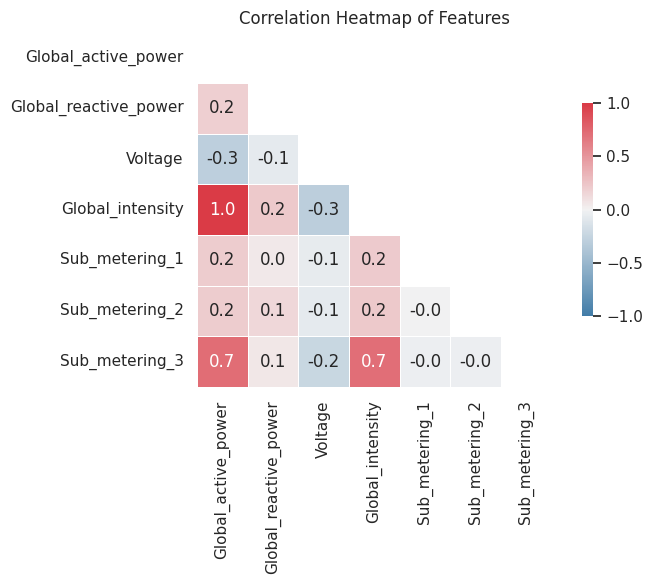

In [87]:
# Compute correlation matrix
corr = df_clean.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
plt.figure(figsize=(8, 6))

cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            annot=True, fmt=".1f", square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.6})
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()


Since Global_active_power and Global_intensity are perfectly correlated, we remove Global_intensity to avoid multicollinearity and redundant information in the model.



In addition, as seen from the earlier histogram, the distribution of `Voltage` is nearly normal with a sharp peak and very small variance, indicating that it behaves almost like a constant. The time series trend also shows minimal fluctuations over time. Given its stability and limited variability, we remove this feature from further analysis.

In [88]:
df = df_clean.drop(["Global_intensity", "Voltage"], axis=1)

According to the paper, we convert the datetime index into several explicit time-based features, such as year, month, day, hour, and minute.

In [89]:
# Convert datetime index to a column
df["Datetime"] = df.index

# Extract time components as separate features
df["Year"] = df["Datetime"].dt.year
df["Month"] = df["Datetime"].dt.month
df["Day"] = df["Datetime"].dt.day
df["Hour"] = df["Datetime"].dt.hour
df["Minute"] = df["Datetime"].dt.minute

# Drop the temporary datetime column (optional)
df.drop("Datetime", axis=1, inplace=True)

# Preview the result
df.head()


,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Month,Day,Hour,Minute
dt,,,,,,,,,,
2006-12-16 17:54:00,2.720,0.000,0.0,0.0,17.0,2006,12,16,17,54
2006-12-16 17:59:00,2.472,0.058,0.0,0.0,17.0,2006,12,16,17,59
2006-12-16 18:00:00,2.790,0.180,0.0,0.0,18.0,2006,12,16,18,0
2006-12-16 18:01:00,2.624,0.144,0.0,0.0,17.0,2006,12,16,18,1
2006-12-16 18:02:00,2.772,0.118,0.0,0.0,17.0,2006,12,16,18,2


## Split training set and test set


The function `prepare_time_series_data()` performs the complete preprocessing pipeline for multivariate time series modeling. It includes:

* **Resampling**: The original data is resampled to a fixed interval (default: hourly) and missing values are removed.
* **Sliding Window Construction**: For each sample, a fixed-length window of past multivariate data is extracted as input `X`, while the future values of the target variable (first column) are used as the output `Y`.
* **Train/Test Split**: The data is split based on a given ratio (default: 80% for training).
* **Normalization**: Inputs and targets are scaled using `MinMaxScaler`, fitted only on the training set to avoid data leakage.
* **Return Values**: The function returns normalized training and testing sets for both `X` and `Y`, along with the fitted scalers for inverse transformation during evaluation.

In [90]:
def prepare_time_series_data(
    df,
    resample_rule='H',
    window_size=60,
    horizon=60,
    train_split_ratio=0.8
):
    # 1. Resample the data (e.g., hourly) and drop missing values
    df_resampled = df.resample(resample_rule).mean().dropna()

    # 2. Convert DataFrame to array and store column order
    cols = df_resampled.columns.tolist()
    data = df_resampled.values.astype(np.float32)

    # 3. Create sliding window samples
    #    X contains past 'window_size' steps of all features
    #    Y contains the next 'horizon' steps of the first feature (target)
    X, Y = [], []
    for i in range(window_size, len(data) - horizon + 1):
        X_window = data[i - window_size:i, :]      # multivariate input
        Y_window = data[i:i + horizon, 0]          # target variable (1st column only)
        X.append(X_window)
        Y.append(Y_window)

    X = np.array(X)  # shape: (num_samples, window_size, num_features)
    Y = np.array(Y)  # shape: (num_samples, horizon)

    # 4. Split into training and testing sets
    num_train = int(len(X) * train_split_ratio)

    # Flatten training data for normalization
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_raw = X[:num_train]  # shape: (N, W, F)
    Y_train_raw = Y[:num_train]  # shape: (N, H)

    # flatten 后 fit
    scaler_x.fit(X_train_raw.reshape(-1, X.shape[2]))
    scaler_y.fit(Y_train_raw.reshape(-1, 1))

    # Apply the scaling to all data and reshape back
    X_scaled = scaler_x.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
    Y_scaled = scaler_y.transform(Y.reshape(-1, 1)).reshape(Y.shape)

    # 6. Final split into train/test sets
    X_train, X_test = X_scaled[:num_train], X_scaled[num_train:]
    Y_train, Y_test = Y_scaled[:num_train], Y_scaled[num_train:]

    return X_train, X_test, Y_train, Y_test, scaler_x, scaler_y


## Modeling


**CNN-LSTM Model:**

The **CNN-2D + LSTM** model is a hybrid deep learning architecture designed to capture both local spatial-temporal patterns and long-term temporal dependencies in multivariate time series data. It combines:

1. **2D Convolutional Neural Networks (CNN-2D)**
   To extract local features across both time and variables within a fixed window.

2. **LSTM (Long Short-Term Memory)**
   To model sequential dynamics over time based on CNN-extracted features.

Model Structure:

* **Input**:
  Reshaped to 4D format: `(batch_size, time_steps, num_features, 1)`
  Each input sample is a small 2D matrix (time × features) treated as an image.

* **Conv2D Layer**:
  Slides over both the time and feature dimensions to extract local joint patterns:

  $$
  \text{Conv2D}(X)_{i,j} = \sum_{m=0}^{k_1-1} \sum_{n=0}^{k_2-1} W_{m,n} \cdot X_{i+m, j+n}
  $$

  where $X \in \mathbb{R}^{T \times F}$ is the input window, and $W$ is a kernel of size $k_1 \times k_2$.

* **Flatten**:
  The CNN output is reshaped into a 3D tensor suitable for LSTM input:
  `(batch_size, new_timesteps, new_features)`

* **LSTM Layer**:
  Models the temporal dependencies based on CNN-extracted features.
  Simplified LSTM cell updates:

  $$
  f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f), \quad
  c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t, \quad
  h_t = o_t \odot \tanh(c_t)
  $$

* **Fully Connected Output Layer**:
  Outputs multi-step forecasts.
  
The architecture of the proposed CNN-2D + LSTM model is illustrated below:


In [91]:
Image(url='https://ars.els-cdn.com/content/image/1-s2.0-S0360544219311223-egi10KKMXJ47S1_lrg.jpg', width=600 )

Additionally, for comparison and alignment with the original paper, we also implement linear regression and a single-layer LSTM model as baseline approaches.

**Memory Issues with Minute-Level Sliding Windows:**

Using minute-level data over two years results in over 1 million rows. According to the paper, when applying a sliding window with `window_size = 60` and `horizon = 60`, this creates around 1,051,080 high-dimensional samples. Storing all of them in memory can easily lead to excessive RAM usage and program crashes. The problem comes from the dense and overlapping nature of sliding windows at high frequencies.

To address this, we limit the input to a period of time when using minute-level data. For larger time spans, we resample the data to lower resolutions—hourly, daily, or weekly—which significantly reduces the number of samples. This makes training deep learning models more memory-efficient while still preserving temporal patterns.


###  Minutely

In [92]:
# Filter data
df_h = df[(df.index >= '2007-01-01') & (df.index < '2008-01-01')]

# Prepare time series data using minute-level resolution ('T')
X_train, X_test, Y_train, Y_test, scaler_x, scaler_y = prepare_time_series_data(
    df_h,
    resample_rule='T',       # 'T' = minutely
    window_size=60,          # Use past 60 minutes as input
    horizon=60,              # Predict the next 60 minutes
    train_split_ratio=0.75    # 80% training, 25% testing
)

# Output shapes and check for NaN values
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)
print("NaN check:", np.isnan(X_train).sum(), np.isnan(Y_train).sum())


<ipython-input-90-59c60cd9ff56>:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(resample_rule).mean().dropna()


X_train: (360835, 60, 10)
Y_train: (360835, 60)
X_test: (120279, 60, 10)
Y_test: (120279, 60)
NaN check: 0 0


#### Linear Regression

We implement a linear regression model as a simple baseline. The input is flattened into a single vector per sample (i.e., no temporal structure is preserved), and the model predicts the entire target horizon at once.

In [94]:
def train_evaluate_linear_regression(X_train, Y_train, X_test, Y_test, scaler_y):

    # 1. Flatten input sequences (remove time dimension)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # 2. Fit a linear regression model
    lr = LinearRegression()
    lr.fit(X_train_flat, Y_train)

    # 3. Predict the target horizon
    yhat_lr = lr.predict(X_test_flat)

    # 4. Inverse transform to original scale
    yhat_lr_inv = scaler_y.inverse_transform(yhat_lr)
    Y_test_inv = scaler_y.inverse_transform(Y_test)

    # 5. Evaluate performance
    rmse = np.sqrt(mean_squared_error(Y_test_inv, yhat_lr_inv))
    mse = mean_squared_error(Y_test_inv, yhat_lr_inv)

    return yhat_lr_inv, Y_test_inv, rmse, mse

# Run and evaluate
Y_pred_lr, Y_true, rmse_lr, mse_lr = train_evaluate_linear_regression(
    X_train, Y_train, X_test, Y_test, scaler_y
)

print(f"RMSE: {rmse_lr:.3f}")
print(f"MSE:  {mse_lr:.3f}")

RMSE: 0.560
MSE:  0.314


#### LTSM

In [95]:
def build_lstm_model(timesteps, n_features, output_steps, units=128, dropout_rate=0.2):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(timesteps, n_features)),
        keras.layers.LSTM(units, activation='tanh'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(output_steps)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

model = build_lstm_model(X_train.shape[1], X_train.shape[2], Y_train.shape[1])
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 128)            │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 60)             │         7,740 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,908 (308.23 KB)

 Trainable params: 78,908 (308.23 KB)

 Non-trainable params: 0 (0.00 B)

`shuffle=False` is important to preserve temporal order in time series.

In [96]:
# Early stopping callback: stop if validation loss doesn't improve for 10 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reshape targets to 3D for LSTM output: (samples, output_steps, 1)
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], 1))

history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=2,
    shuffle=False,
    callbacks=[early_stop]
)

Epoch 1/50
4511/4511 - 29s - 6ms/step - loss: 0.0332 - val_loss: 0.0288
Epoch 2/50
4511/4511 - 28s - 6ms/step - loss: 0.0289 - val_loss: 0.0280
Epoch 3/50
4511/4511 - 28s - 6ms/step - loss: 0.0283 - val_loss: 0.0277
Epoch 4/50
4511/4511 - 27s - 6ms/step - loss: 0.0278 - val_loss: 0.0275
Epoch 5/50
4511/4511 - 27s - 6ms/step - loss: 0.0276 - val_loss: 0.0275
Epoch 6/50
4511/4511 - 27s - 6ms/step - loss: 0.0273 - val_loss: 0.0271
Epoch 7/50
4511/4511 - 27s - 6ms/step - loss: 0.0270 - val_loss: 0.0267
Epoch 8/50
4511/4511 - 28s - 6ms/step - loss: 0.0269 - val_loss: 0.0267
Epoch 9/50
4511/4511 - 28s - 6ms/step - loss: 0.0267 - val_loss: 0.0267
Epoch 10/50
4511/4511 - 28s - 6ms/step - loss: 0.0265 - val_loss: 0.0268
Epoch 11/50
4511/4511 - 28s - 6ms/step - loss: 0.0264 - val_loss: 0.0268
Epoch 12/50
4511/4511 - 27s - 6ms/step - loss: 0.0263 - val_loss: 0.0266
Epoch 13/50
4511/4511 - 27s - 6ms/step - loss: 0.0262 - val_loss: 0.0266
Epoch 14/50
4511/4511 - 27s - 6ms/step - loss: 0.0261 - val_

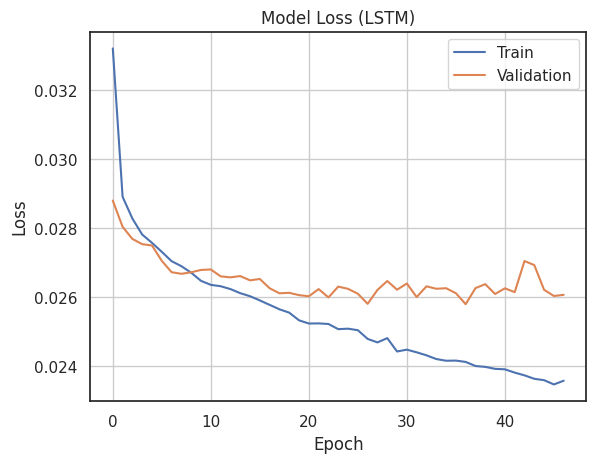

In [97]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (LSTM)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

In [98]:
# Predict on the test set
yhat_scaled = model.predict(X_test)

# yhat_scaled already has shape (samples, output_steps)
Y_pred_lstm = scaler_y.inverse_transform(yhat_scaled)

# Inverse transform the ground truth
Y_test_2d = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])
Y_test_inv = scaler_y.inverse_transform(Y_test_2d)

# Compute evaluation metrics
rmse = np.sqrt(mean_squared_error(Y_test_inv.flatten(), Y_pred_lstm.flatten()))
mse = mean_squared_error(Y_test_inv.flatten(), Y_pred_lstm.flatten())

print(f'RMSE: {rmse:.3f}')
print(f'MSE:  {mse:.3f}')

3759/3759 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
RMSE: 0.585
MSE:  0.342


#### CNN LSTM


We implement a CNN-LSTM hybrid model that exactly follows the architecture described in the original paper:

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Conv2D, MaxPooling2D, TimeDistributed, Flatten, LSTM, Dense

def build_cnn_lstm_model(window_size, fea_num, output_steps):
    model = keras.models.Sequential([
        keras.layers.Input((window_size, fea_num)),
        keras.layers.Reshape((window_size, fea_num, 1)),

        # Conv Block 1
        keras.layers.Conv2D(filters=64,
                            kernel_size=(2,1),
                            strides=1,
                            padding="same",
                            activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2,1), strides=1, padding="same"),

        # Conv Block 2
        keras.layers.Conv2D(filters=64,
                            kernel_size=(2,1),
                            strides=1,
                            padding="same",
                            activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2,1), strides=1, padding="same"),

        # Reshape back to 3D for LSTM
        keras.layers.Reshape((window_size, -1)),
        keras.layers.LSTM(64, return_sequences=False, activation="tanh"),

        # Fully connected layers
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(output_steps)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

model = build_cnn_lstm_model(X_train.shape[1], X_train.shape[2], Y_train.shape[1])
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_22 (Reshape)            │ (None, 60, 10, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 60, 10, 64)     │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 60, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 60, 10, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 60, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_23 (Reshape)            │ (None, 60, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 64)             │       180,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 60)             │         1,980 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,988 (753.86 KB)

 Trainable params: 192,988 (753.86 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    shuffle=False,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/50
4511/4511 - 37s - 8ms/step - loss: 0.0327 - val_loss: 0.0300
Epoch 2/50
4511/4511 - 34s - 8ms/step - loss: 0.0289 - val_loss: 0.0279
Epoch 3/50
4511/4511 - 34s - 7ms/step - loss: 0.0281 - val_loss: 0.0275
Epoch 4/50
4511/4511 - 34s - 7ms/step - loss: 0.0275 - val_loss: 0.0277
Epoch 5/50
4511/4511 - 34s - 7ms/step - loss: 0.0273 - val_loss: 0.0273
Epoch 6/50
4511/4511 - 34s - 8ms/step - loss: 0.0270 - val_loss: 0.0270
Epoch 7/50
4511/4511 - 34s - 8ms/step - loss: 0.0267 - val_loss: 0.0271
Epoch 8/50
4511/4511 - 34s - 7ms/step - loss: 0.0265 - val_loss: 0.0272
Epoch 9/50
4511/4511 - 34s - 8ms/step - loss: 0.0264 - val_loss: 0.0268
Epoch 10/50
4511/4511 - 33s - 7ms/step - loss: 0.0261 - val_loss: 0.0271
Epoch 11/50
4511/4511 - 34s - 7ms/step - loss: 0.0259 - val_loss: 0.0272
Epoch 12/50
4511/4511 - 34s - 7ms/step - loss: 0.0258 - val_loss: 0.0270
Epoch 13/50
4511/4511 - 34s - 7ms/step - loss: 0.0256 - val_loss: 0.0274
Epoch 14/50
4511/4511 - 33s - 7ms/step - loss: 0.0254 - val_

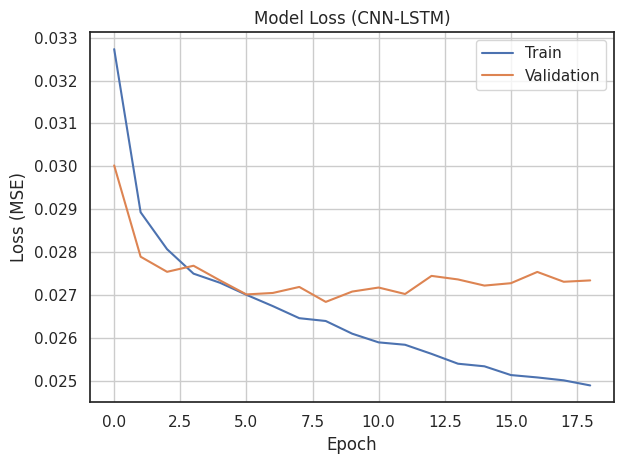

In [101]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss (CNN-LSTM)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [60]:
yhat_scaled = model.predict(X_test)

# reshape  (samples, steps)
if yhat_scaled.ndim == 3:
    yhat_scaled = yhat_scaled.reshape(yhat_scaled.shape[0], yhat_scaled.shape[1])
if Y_test.ndim == 3:
    Y_test_2d = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])
else:
    Y_test_2d = Y_test

yhat_inv = scaler_y.inverse_transform(yhat_scaled)
Y_pred_cnn = yhat_inv
Y_test_inv = scaler_y.inverse_transform(Y_test_2d)

rmse = np.sqrt(mean_squared_error(Y_test_inv, yhat_inv))
mse = mean_squared_error(Y_test_inv, yhat_inv)

print(f"RMSE: {rmse:.3f}")
print(f"MSE:  {mse:.3f}")

1839/1839 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
RMSE: 0.520
MSE:  0.271


#### Prediction

In [102]:
def plot_forecast_comparison(
    sample_indices,
    Y_true,
    Y_pred_lr=None,
    Y_pred_lstm=None,
    Y_pred_cnn=None,
    ylabel="Global Active Power (kW)",
    title_prefix="Forecast Comparison"
):
    assert len(sample_indices) == 2, "Please provide exactly 2 sample indices"

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)
    steps = Y_true.shape[1]
    t = np.arange(steps)

    for i, sample_idx in enumerate(sample_indices):
        ax = axes[i]
        ax.plot(t, Y_true[sample_idx], 'k-o', label='Ground truth')
        if Y_pred_cnn is not None:
            ax.plot(t, Y_pred_cnn[sample_idx], 'r-o', label='CNN-LSTM')
        if Y_pred_lr is not None:
            ax.plot(t, Y_pred_lr[sample_idx], 'b-^', label='Linear regression')
        if Y_pred_lstm is not None:
            ax.plot(t, Y_pred_lstm[sample_idx], 'g-s', label='LSTM')

        ax.set_title(f"{title_prefix} (Sample {sample_idx})")
        ax.set_xlabel("Forecast step")
        ax.set_ylabel(ylabel)
        ax.grid(True)

    # Unified legend on top
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, fontsize='large')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


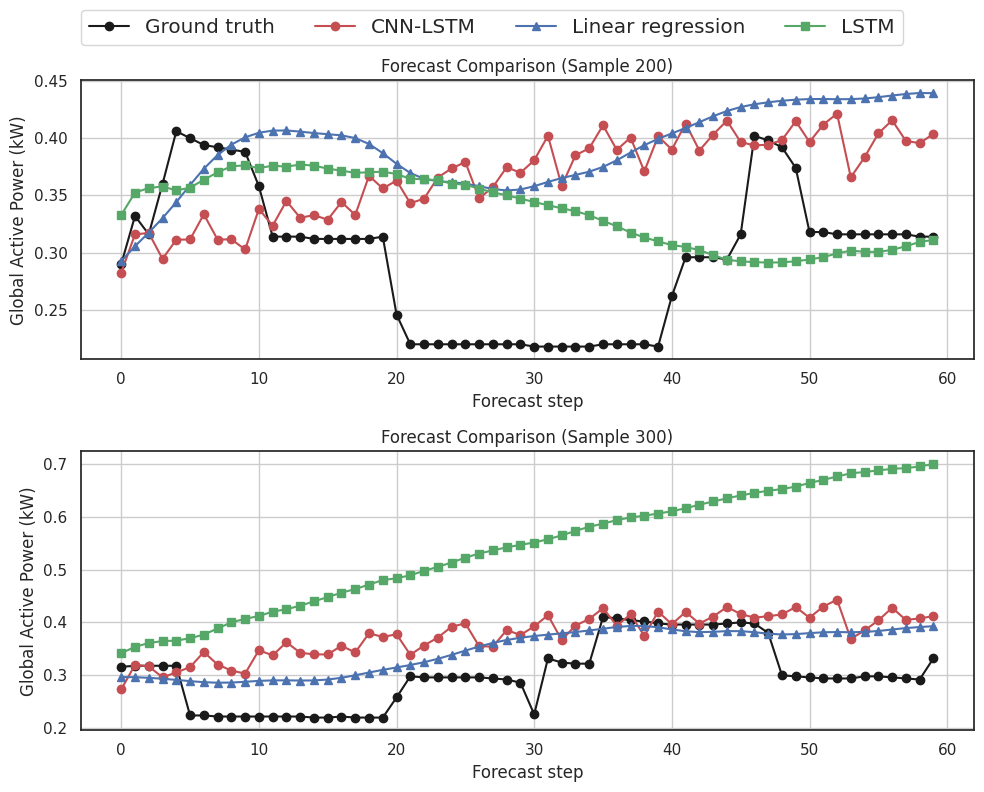

In [107]:
plot_forecast_comparison(
    sample_indices=[200, 300],
    Y_true=Y_true,
    Y_pred_lr=Y_pred_lr,
    Y_pred_lstm=Y_pred_lstm,
    Y_pred_cnn=Y_pred_cnn
)


### Hourly

In [108]:
X_train, X_test, Y_train, Y_test, scaler_x, scaler_y = prepare_time_series_data(
    df,
    resample_rule='H',
    window_size=48,
    horizon=24,
    train_split_ratio=0.75
)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)
print("NaN check:", np.isnan(X_train).sum(), np.isnan(Y_train).sum())


<ipython-input-90-59c60cd9ff56>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample(resample_rule).mean().dropna()


X_train: (25508, 48, 10)
Y_train: (25508, 24)
X_test: (8503, 48, 10)
Y_test: (8503, 24)
NaN check: 0 0


#### LR

In [109]:
Y_pred_lr, Y_true, rmse_lr, mse_lr = train_evaluate_linear_regression(
    X_train, Y_train, X_test, Y_test, scaler_y
)
print(f"[Linear Regression] RMSE: {rmse_lr:.3f}")
print(f"[Linear Regression] MSE:  {mse_lr:.3f}")

[Linear Regression] RMSE: 0.511
[Linear Regression] MSE:  0.261


#### LSTM

Epoch 1/50
319/319 - 3s - 10ms/step - loss: 0.0606 - val_loss: 0.0435
Epoch 2/50
319/319 - 2s - 6ms/step - loss: 0.0475 - val_loss: 0.0361
Epoch 3/50
319/319 - 2s - 6ms/step - loss: 0.0437 - val_loss: 0.0364
Epoch 4/50
319/319 - 2s - 6ms/step - loss: 0.0426 - val_loss: 0.0369
Epoch 5/50
319/319 - 2s - 6ms/step - loss: 0.0419 - val_loss: 0.0364
Epoch 6/50
319/319 - 2s - 6ms/step - loss: 0.0410 - val_loss: 0.0371
Epoch 7/50
319/319 - 2s - 6ms/step - loss: 0.0405 - val_loss: 0.0365
Epoch 8/50
319/319 - 2s - 6ms/step - loss: 0.0395 - val_loss: 0.0359
Epoch 9/50
319/319 - 2s - 6ms/step - loss: 0.0388 - val_loss: 0.0348
Epoch 10/50
319/319 - 2s - 6ms/step - loss: 0.0384 - val_loss: 0.0340
Epoch 11/50
319/319 - 2s - 6ms/step - loss: 0.0380 - val_loss: 0.0337
Epoch 12/50
319/319 - 2s - 6ms/step - loss: 0.0376 - val_loss: 0.0327
Epoch 13/50
319/319 - 2s - 6ms/step - loss: 0.0373 - val_loss: 0.0322
Epoch 14/50
319/319 - 2s - 6ms/step - loss: 0.0370 - val_loss: 0.0319
Epoch 15/50
319/319 - 2s - 6

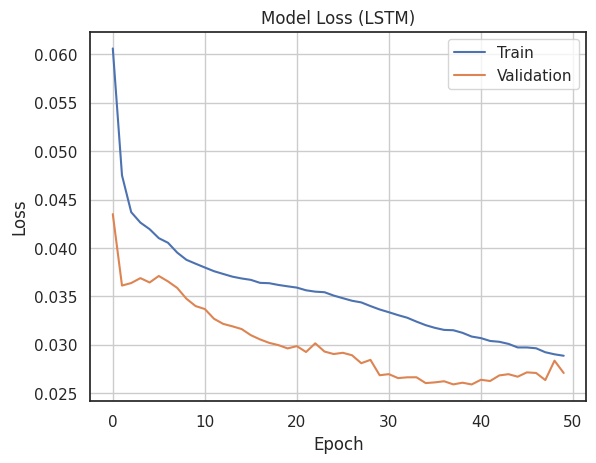

266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test RMSE: 0.521
Test MSE:  0.272


In [110]:
model = build_lstm_model(X_train.shape[1], X_train.shape[2], Y_train.shape[1])

Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], 1))
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=2,
    shuffle=False,
    callbacks=[early_stop]
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (LSTM)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

yhat_scaled = model.predict(X_test)  # shape = (samples, output_steps)

Y_pred_lstm = scaler_y.inverse_transform(yhat_scaled)
Y_test_2d = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])  # or .squeeze(-1)
Y_test_inv = scaler_y.inverse_transform(Y_test_2d)

rmse = np.sqrt(mean_squared_error(Y_test_inv.flatten(), Y_pred_lstm.flatten()))
mse = mean_squared_error(Y_test_inv.flatten(), Y_pred_lstm.flatten())

print(f'Test RMSE: {rmse:.3f}')
print(f'Test MSE:  {mse:.3f}')

#### CNN-LSTM

Epoch 1/50
319/319 - 5s - 14ms/step - loss: 0.0635 - val_loss: 0.0436
Epoch 2/50
319/319 - 2s - 7ms/step - loss: 0.0493 - val_loss: 0.0396
Epoch 3/50
319/319 - 2s - 7ms/step - loss: 0.0435 - val_loss: 0.0380
Epoch 4/50
319/319 - 2s - 7ms/step - loss: 0.0421 - val_loss: 0.0406
Epoch 5/50
319/319 - 2s - 7ms/step - loss: 0.0410 - val_loss: 0.0406
Epoch 6/50
319/319 - 2s - 7ms/step - loss: 0.0401 - val_loss: 0.0398
Epoch 7/50
319/319 - 2s - 7ms/step - loss: 0.0388 - val_loss: 0.0380
Epoch 8/50
319/319 - 2s - 7ms/step - loss: 0.0377 - val_loss: 0.0367
Epoch 9/50
319/319 - 2s - 7ms/step - loss: 0.0371 - val_loss: 0.0345
Epoch 10/50
319/319 - 2s - 7ms/step - loss: 0.0364 - val_loss: 0.0326
Epoch 11/50
319/319 - 2s - 7ms/step - loss: 0.0358 - val_loss: 0.0311
Epoch 12/50
319/319 - 2s - 8ms/step - loss: 0.0351 - val_loss: 0.0302
Epoch 13/50
319/319 - 2s - 8ms/step - loss: 0.0344 - val_loss: 0.0304
Epoch 14/50
319/319 - 2s - 8ms/step - loss: 0.0339 - val_loss: 0.0309
Epoch 15/50
319/319 - 2s - 7

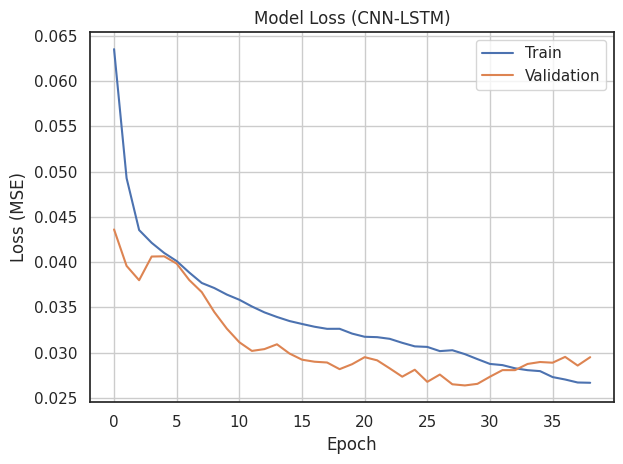

266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test RMSE: 0.532
Test MSE:  0.283


In [111]:
model = build_cnn_lstm_model(X_train.shape[1], X_train.shape[2], Y_train.shape[1])

history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    shuffle=False,
    callbacks=[early_stop],
    verbose=2
)


plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss (CNN-LSTM)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

yhat_scaled = model.predict(X_test)

if yhat_scaled.ndim == 3:
    yhat_scaled = yhat_scaled.reshape(yhat_scaled.shape[0], yhat_scaled.shape[1])
if Y_test.ndim == 3:
    Y_test_2d = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])
else:
    Y_test_2d = Y_test

yhat_inv = scaler_y.inverse_transform(yhat_scaled)
Y_pred_cnn = yhat_inv
Y_test_inv = scaler_y.inverse_transform(Y_test_2d)

rmse = np.sqrt(mean_squared_error(Y_test_inv, yhat_inv))
mse = mean_squared_error(Y_test_inv, yhat_inv)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MSE:  {mse:.3f}")

#### Predction

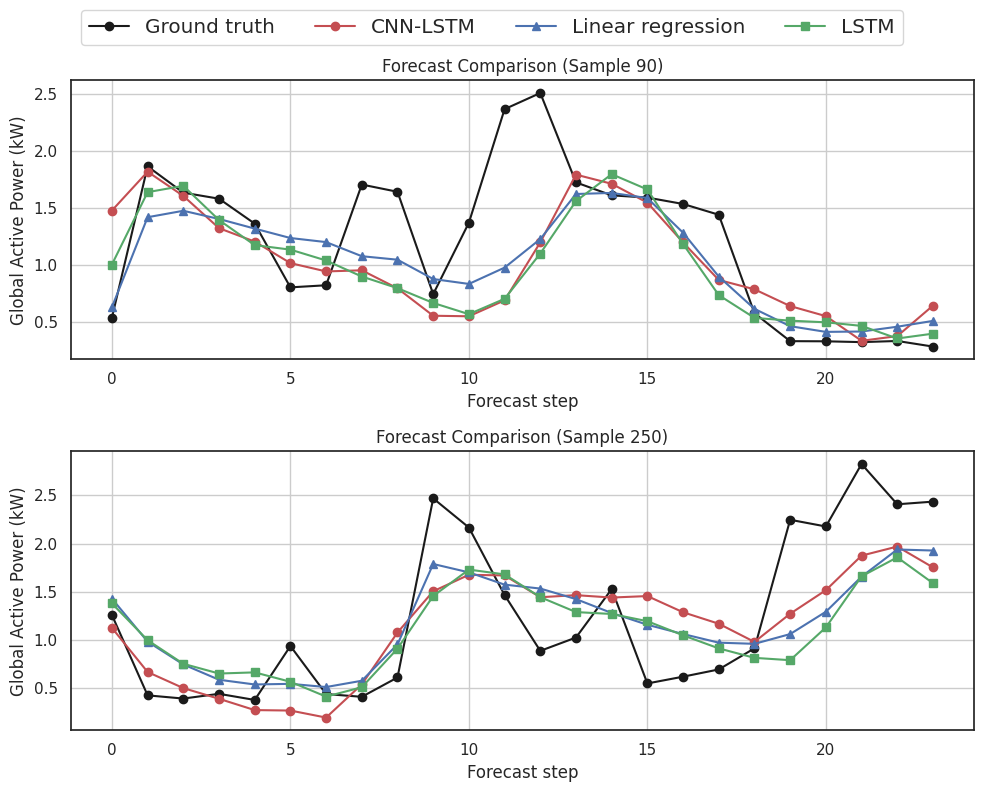

In [113]:
plot_forecast_comparison(
    sample_indices=[90, 250],
    Y_true=Y_true,
    Y_pred_lr=Y_pred_lr,
    Y_pred_lstm=Y_pred_lstm,
    Y_pred_cnn=Y_pred_cnn
)

### Daily

In [114]:
X_train, X_test, Y_train, Y_test, scaler_x, scaler_y = prepare_time_series_data(
    df,
    resample_rule='D',
    window_size=14,
    horizon=5,
    train_split_ratio=0.75
)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)
print("NaN check:", np.isnan(X_train).sum(), np.isnan(Y_train).sum())


X_train: (1061, 14, 10)
Y_train: (1061, 5)
X_test: (354, 14, 10)
Y_test: (354, 5)
NaN check: 0 0


#### LR

In [115]:
Y_pred_lr, Y_true, rmse_lr, mse_lr = train_evaluate_linear_regression(
    X_train, Y_train, X_test, Y_test, scaler_y
)
print(f"RMSE: {rmse_lr:.3f}")
print(f"MSE:  {mse_lr:.3f}")

RMSE: 0.237
MSE:  0.056


#### LSTM

Epoch 1/50
14/14 - 1s - 107ms/step - loss: 0.0517 - val_loss: 0.0140
Epoch 2/50
14/14 - 0s - 10ms/step - loss: 0.0304 - val_loss: 0.0162
Epoch 3/50
14/14 - 0s - 10ms/step - loss: 0.0270 - val_loss: 0.0105
Epoch 4/50
14/14 - 0s - 10ms/step - loss: 0.0238 - val_loss: 0.0090
Epoch 5/50
14/14 - 0s - 10ms/step - loss: 0.0215 - val_loss: 0.0081
Epoch 6/50
14/14 - 0s - 10ms/step - loss: 0.0202 - val_loss: 0.0083
Epoch 7/50
14/14 - 0s - 10ms/step - loss: 0.0200 - val_loss: 0.0077
Epoch 8/50
14/14 - 0s - 10ms/step - loss: 0.0194 - val_loss: 0.0075
Epoch 9/50
14/14 - 0s - 10ms/step - loss: 0.0198 - val_loss: 0.0075
Epoch 10/50
14/14 - 0s - 10ms/step - loss: 0.0193 - val_loss: 0.0075
Epoch 11/50
14/14 - 0s - 10ms/step - loss: 0.0194 - val_loss: 0.0074
Epoch 12/50
14/14 - 0s - 10ms/step - loss: 0.0201 - val_loss: 0.0076
Epoch 13/50
14/14 - 0s - 10ms/step - loss: 0.0210 - val_loss: 0.0085
Epoch 14/50
14/14 - 0s - 10ms/step - loss: 0.0213 - val_loss: 0.0091
Epoch 15/50
14/14 - 0s - 10ms/step - loss:

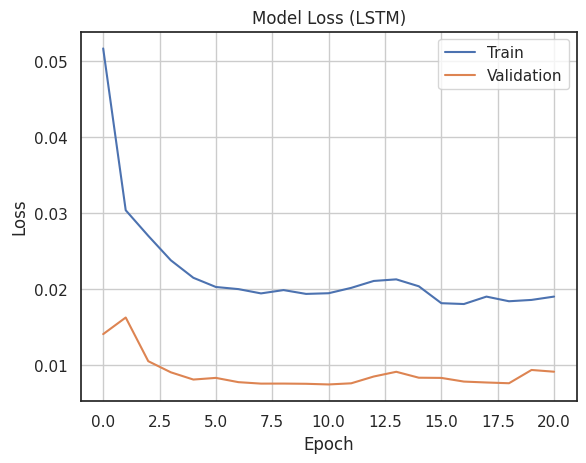

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test RMSE: 0.196
Test MSE:  0.038


In [116]:
model = build_lstm_model(X_train.shape[1], X_train.shape[2], Y_train.shape[1])

Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], 1))
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=2,
    shuffle=False,
    callbacks=[early_stop]
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (LSTM)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

yhat_scaled = model.predict(X_test)  # shape = (samples, output_steps)

Y_pred_lstm = scaler_y.inverse_transform(yhat_scaled)
Y_test_2d = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])
Y_test_inv = scaler_y.inverse_transform(Y_test_2d)

rmse = np.sqrt(mean_squared_error(Y_test_inv.flatten(), Y_pred_lstm.flatten()))
mse = mean_squared_error(Y_test_inv.flatten(), Y_pred_lstm.flatten())

print(f'Test RMSE: {rmse:.3f}')
print(f'Test MSE:  {mse:.3f}')

#### CNN-LSTM

Epoch 1/50
14/14 - 3s - 183ms/step - loss: 0.0668 - val_loss: 0.0155
Epoch 2/50
14/14 - 0s - 12ms/step - loss: 0.0305 - val_loss: 0.0154
Epoch 3/50
14/14 - 0s - 12ms/step - loss: 0.0253 - val_loss: 0.0164
Epoch 4/50
14/14 - 0s - 12ms/step - loss: 0.0234 - val_loss: 0.0130
Epoch 5/50
14/14 - 0s - 13ms/step - loss: 0.0217 - val_loss: 0.0110
Epoch 6/50
14/14 - 0s - 12ms/step - loss: 0.0197 - val_loss: 0.0091
Epoch 7/50
14/14 - 0s - 12ms/step - loss: 0.0180 - val_loss: 0.0081
Epoch 8/50
14/14 - 0s - 12ms/step - loss: 0.0169 - val_loss: 0.0076
Epoch 9/50
14/14 - 0s - 12ms/step - loss: 0.0163 - val_loss: 0.0072
Epoch 10/50
14/14 - 0s - 13ms/step - loss: 0.0161 - val_loss: 0.0072
Epoch 11/50
14/14 - 0s - 12ms/step - loss: 0.0160 - val_loss: 0.0071
Epoch 12/50
14/14 - 0s - 12ms/step - loss: 0.0158 - val_loss: 0.0072
Epoch 13/50
14/14 - 0s - 12ms/step - loss: 0.0157 - val_loss: 0.0071
Epoch 14/50
14/14 - 0s - 12ms/step - loss: 0.0157 - val_loss: 0.0071
Epoch 15/50
14/14 - 0s - 12ms/step - loss:

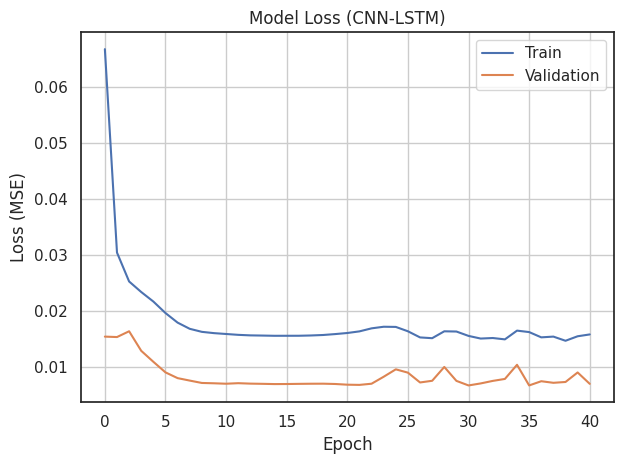

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test RMSE: 0.181
Test MSE:  0.033


In [117]:
model = build_cnn_lstm_model(X_train.shape[1], X_train.shape[2], Y_train.shape[1])

history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    shuffle=False,
    callbacks=[early_stop],
    verbose=2
)

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss (CNN-LSTM)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

yhat_scaled = model.predict(X_test)

if yhat_scaled.ndim == 3:
    yhat_scaled = yhat_scaled.reshape(yhat_scaled.shape[0], yhat_scaled.shape[1])
if Y_test.ndim == 3:
    Y_test_2d = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])
else:
    Y_test_2d = Y_test


yhat_inv = scaler_y.inverse_transform(yhat_scaled)
Y_pred_cnn = yhat_inv
Y_test_inv = scaler_y.inverse_transform(Y_test_2d)


rmse = np.sqrt(mean_squared_error(Y_test_inv, yhat_inv))
mse = mean_squared_error(Y_test_inv, yhat_inv)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MSE:  {mse:.3f}")

#### Prediction

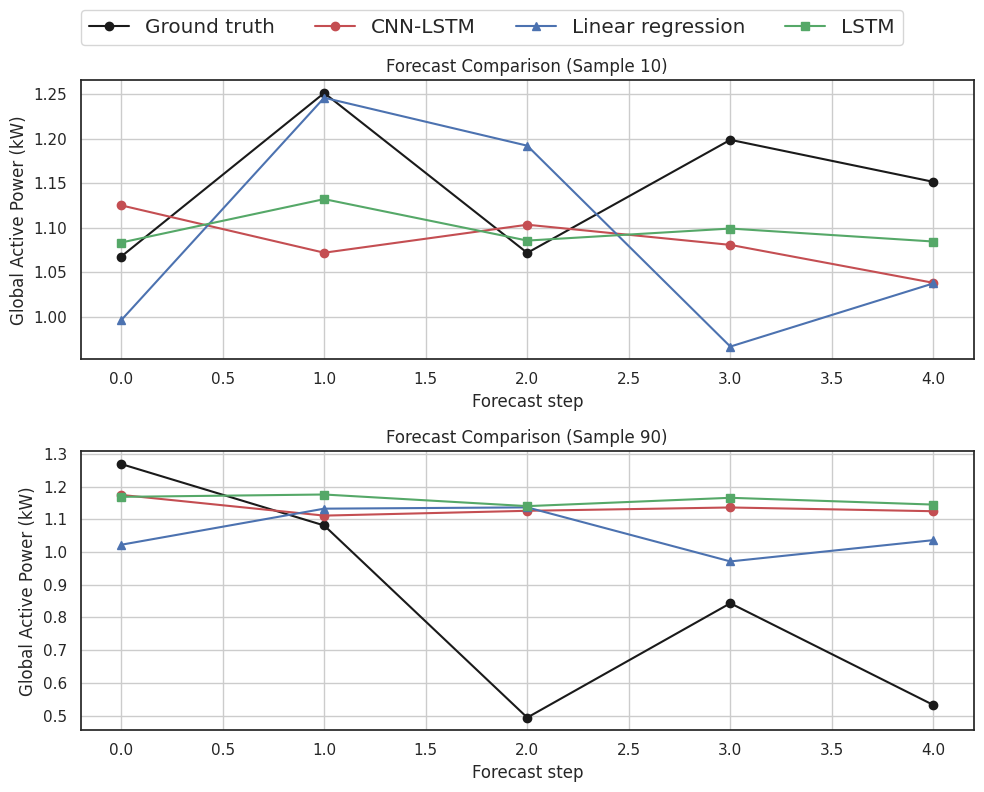

In [118]:
plot_forecast_comparison(
    sample_indices=[10, 90],
    Y_true=Y_true,
    Y_pred_lr=Y_pred_lr,
    Y_pred_lstm=Y_pred_lstm,
    Y_pred_cnn=Y_pred_cnn
)


### Weekly

In [119]:
X_train, X_test, Y_train, Y_test, scaler_x, scaler_y = prepare_time_series_data(
    df,
    resample_rule='W',
    window_size=8,
    horizon=3,
    train_split_ratio=0.75
)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)
print("NaN check:", np.isnan(X_train).sum(), np.isnan(Y_train).sum())


X_train: (147, 8, 10)
Y_train: (147, 3)
X_test: (50, 8, 10)
Y_test: (50, 3)
NaN check: 0 0


#### LR

In [120]:
Y_pred_lr, Y_true, rmse_lr, mse_lr = train_evaluate_linear_regression(
    X_train, Y_train, X_test, Y_test, scaler_y
)
print(f"[Linear Regression] RMSE: {rmse_lr:.3f}")
print(f"[Linear Regression] MSE:  {mse_lr:.3f}")

[Linear Regression] RMSE: 0.199
[Linear Regression] MSE:  0.040


#### LSTM

Epoch 1/50
2/2 - 1s - 720ms/step - loss: 0.3823 - val_loss: 0.1771
Epoch 2/50
2/2 - 0s - 44ms/step - loss: 0.2327 - val_loss: 0.0703
Epoch 3/50
2/2 - 0s - 45ms/step - loss: 0.1256 - val_loss: 0.0304
Epoch 4/50
2/2 - 0s - 42ms/step - loss: 0.0654 - val_loss: 0.0750
Epoch 5/50
2/2 - 0s - 42ms/step - loss: 0.0641 - val_loss: 0.1553
Epoch 6/50
2/2 - 0s - 43ms/step - loss: 0.0839 - val_loss: 0.1559
Epoch 7/50
2/2 - 0s - 43ms/step - loss: 0.0733 - val_loss: 0.1070
Epoch 8/50
2/2 - 0s - 43ms/step - loss: 0.0563 - val_loss: 0.0630
Epoch 9/50
2/2 - 0s - 43ms/step - loss: 0.0456 - val_loss: 0.0391
Epoch 10/50
2/2 - 0s - 44ms/step - loss: 0.0474 - val_loss: 0.0299
Epoch 11/50
2/2 - 0s - 44ms/step - loss: 0.0488 - val_loss: 0.0277
Epoch 12/50
2/2 - 0s - 44ms/step - loss: 0.0476 - val_loss: 0.0281
Epoch 13/50
2/2 - 0s - 42ms/step - loss: 0.0486 - val_loss: 0.0299
Epoch 14/50
2/2 - 0s - 43ms/step - loss: 0.0456 - val_loss: 0.0338
Epoch 15/50
2/2 - 0s - 42ms/step - loss: 0.0419 - val_loss: 0.0402
Epo

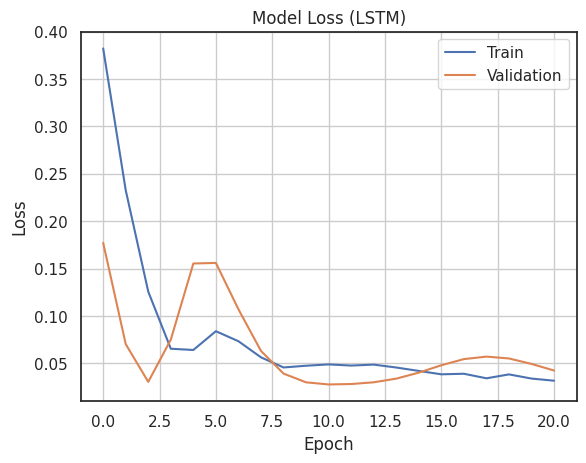

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Test RMSE: 0.214
Test MSE:  0.046


In [121]:
model = build_lstm_model(X_train.shape[1], X_train.shape[2], Y_train.shape[1])

Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], 1))
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=2,
    shuffle=False,
    callbacks=[early_stop]
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (LSTM)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

yhat_scaled = model.predict(X_test)  # shape = (samples, output_steps)

Y_pred_lstm = scaler_y.inverse_transform(yhat_scaled)
Y_test_2d = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])  # or .squeeze(-1)
Y_test_inv = scaler_y.inverse_transform(Y_test_2d)

rmse = np.sqrt(mean_squared_error(Y_test_inv.flatten(), Y_pred_lstm.flatten()))
mse = mean_squared_error(Y_test_inv.flatten(), Y_pred_lstm.flatten())

print(f'Test RMSE: {rmse:.3f}')
print(f'Test MSE:  {mse:.3f}')

#### CNN-LSTM

Epoch 1/50
2/2 - 2s - 1s/step - loss: 0.3618 - val_loss: 0.1621
Epoch 2/50
2/2 - 0s - 48ms/step - loss: 0.1901 - val_loss: 0.0364
Epoch 3/50
2/2 - 0s - 44ms/step - loss: 0.0631 - val_loss: 0.0806
Epoch 4/50
2/2 - 0s - 43ms/step - loss: 0.0710 - val_loss: 0.1532
Epoch 5/50
2/2 - 0s - 43ms/step - loss: 0.0826 - val_loss: 0.0785
Epoch 6/50
2/2 - 0s - 44ms/step - loss: 0.0444 - val_loss: 0.0287
Epoch 7/50
2/2 - 0s - 44ms/step - loss: 0.0390 - val_loss: 0.0231
Epoch 8/50
2/2 - 0s - 43ms/step - loss: 0.0509 - val_loss: 0.0242
Epoch 9/50
2/2 - 0s - 45ms/step - loss: 0.0519 - val_loss: 0.0218
Epoch 10/50
2/2 - 0s - 44ms/step - loss: 0.0424 - val_loss: 0.0252
Epoch 11/50
2/2 - 0s - 43ms/step - loss: 0.0352 - val_loss: 0.0386
Epoch 12/50
2/2 - 0s - 43ms/step - loss: 0.0360 - val_loss: 0.0504
Epoch 13/50
2/2 - 0s - 44ms/step - loss: 0.0382 - val_loss: 0.0488
Epoch 14/50
2/2 - 0s - 43ms/step - loss: 0.0358 - val_loss: 0.0380
Epoch 15/50
2/2 - 0s - 43ms/step - loss: 0.0321 - val_loss: 0.0281
Epoch 

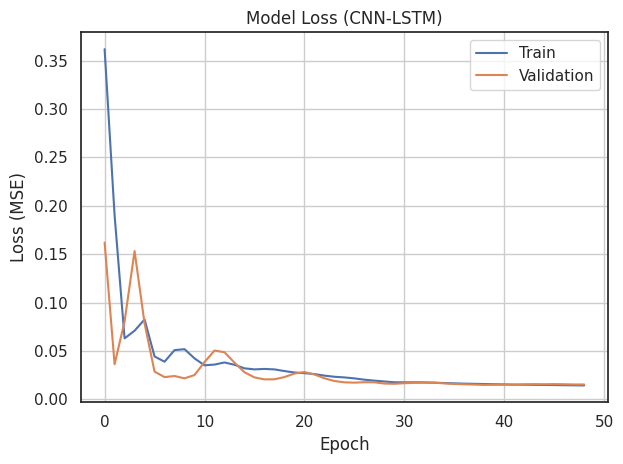

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Test RMSE: 0.133
Test MSE:  0.018


In [122]:
model = build_cnn_lstm_model(X_train.shape[1], X_train.shape[2], Y_train.shape[1])

history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    shuffle=False,
    callbacks=[early_stop],
    verbose=2
)


plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss (CNN-LSTM)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

yhat_scaled = model.predict(X_test)

if yhat_scaled.ndim == 3:
    yhat_scaled = yhat_scaled.reshape(yhat_scaled.shape[0], yhat_scaled.shape[1])
if Y_test.ndim == 3:
    Y_test_2d = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])
else:
    Y_test_2d = Y_test

yhat_inv = scaler_y.inverse_transform(yhat_scaled)
Y_pred_cnn = yhat_inv
Y_test_inv = scaler_y.inverse_transform(Y_test_2d)

rmse = np.sqrt(mean_squared_error(Y_test_inv, yhat_inv))
mse = mean_squared_error(Y_test_inv, yhat_inv)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MSE:  {mse:.3f}")

#### Predction

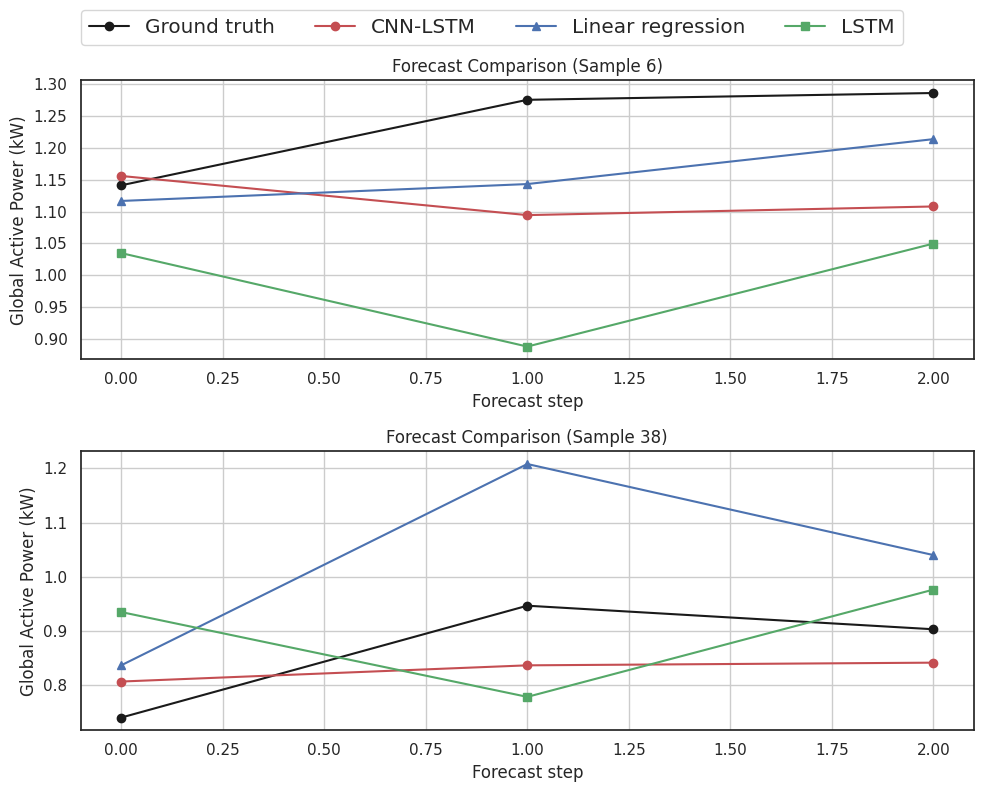

In [125]:
plot_forecast_comparison(
    sample_indices=[6, 38],
    Y_true=Y_true,
    Y_pred_lr=Y_pred_lr,
    Y_pred_lstm=Y_pred_lstm,
    Y_pred_cnn=Y_pred_cnn
)
